# Does my new central heating boiler help with these crazy high gas prices?
*Where we use linear regression with interactions to benchmark the performance of my new central heating boiler in an energy crisis*

# Introduction
With the conflict raging in Eastern Europe, one of the side-effects is skyrocketing energy prices. My gas prices easily quadrupled since the start of the year, so like a good nerd type data scientist I started to study my energy usage data to assuage my worries. Luckily, my energy provider allowed me to download daily gas usage data for the last few years. One of the first things that struck me was that our gas usage this year was lower than I expected based on the previous years. One of the prime suspects that could cause this was the installation of a new central heating boiler at the end of april 2022, as it is the only appliance that uses gas. 

In this article we explore my energy data, and build a regression model including interactions that quantifies just how much my new central heating boiler influences my gas usage. 

# Daily gas usage and temperature
The primary data source is the website of my energy supplier, Eneco. From their online system they allow me to download an Excel sheet with daily energy usage. Note that I normalised my usage data (min-max scaled) to protect my data privacy. In addition, I also [downloaded temperature data](https://daggegevens.knmi.nl/klimatologie/daggegevens) for a weather station nearby as I suspect the gas usage will depend strongly on outside temperature. The following code reads the data and merges both datasets based on date:

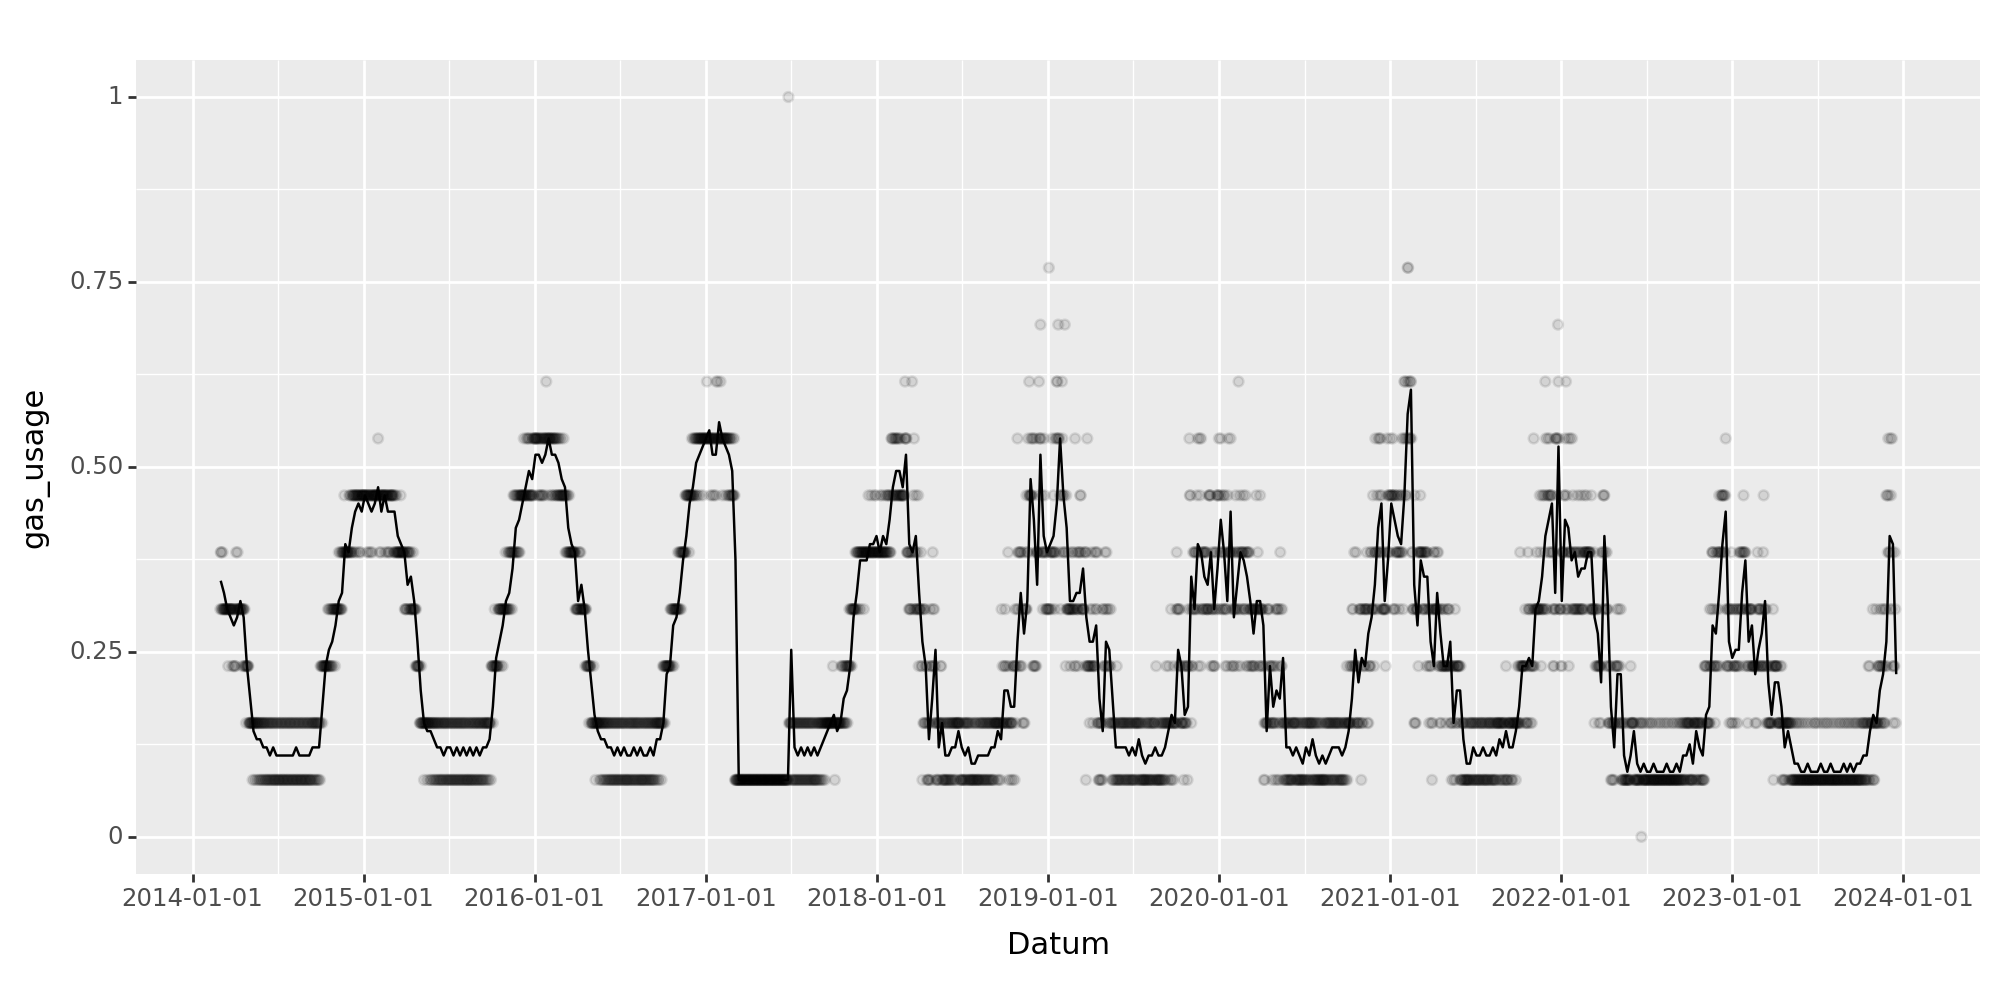

<Figure Size: (1000 x 500)>

In [6]:
import pandas as pd
from local_functions import *
from plotnine import *
import calendar

energy_usage = pd.read_excel('data/usage_anonymized.xlsx', index_col=[0])
temperature = read_knmi('data/knmi_weather.txt')

gas_usage = (
    energy_usage['gas_usage']
        .reset_index()
        .merge(temperature.reset_index(), 
                left_on='Datum', right_on='date')
    )

(
    ggplot(gas_usage, aes(x='Datum', y='gas_usage')) 
      + geom_point(alpha=0.1)
      + geom_line(data=energy_usage['gas_usage'].resample('W').mean().reset_index())
      + theme(figure_size=(10,5))
)

In [7]:
# Highres plot save
gg = (
    ggplot(gas_usage, aes(x='Datum', y='gas_usage')) 
      + geom_point(alpha=0.1)
      + geom_line(data=energy_usage['gas_usage'].resample('W').mean().reset_index())
      + theme(figure_size=(10,5))
)
ggsave(gg, 'pics/gas_usage_years.png', dpi=200)

/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: pics/gas_usage_years.png


where the dots are the daily gas usage values, and the line the weekly average. This clearly shows the yearly trend in gas usage with high usage in winter and lower in summer. A very striking feature is that the daily values accumulate on horizontal lines. This is due to the gas usage being reported in integer increments, effectively rounding the values down to the lowest closest integer. To mitigate this integer effect we resample the whole dataset to weekly summed gas usage and weekly averaged temperatures. Using this resampled data we create a plot that visualises the relationship of temperature to gas usage:

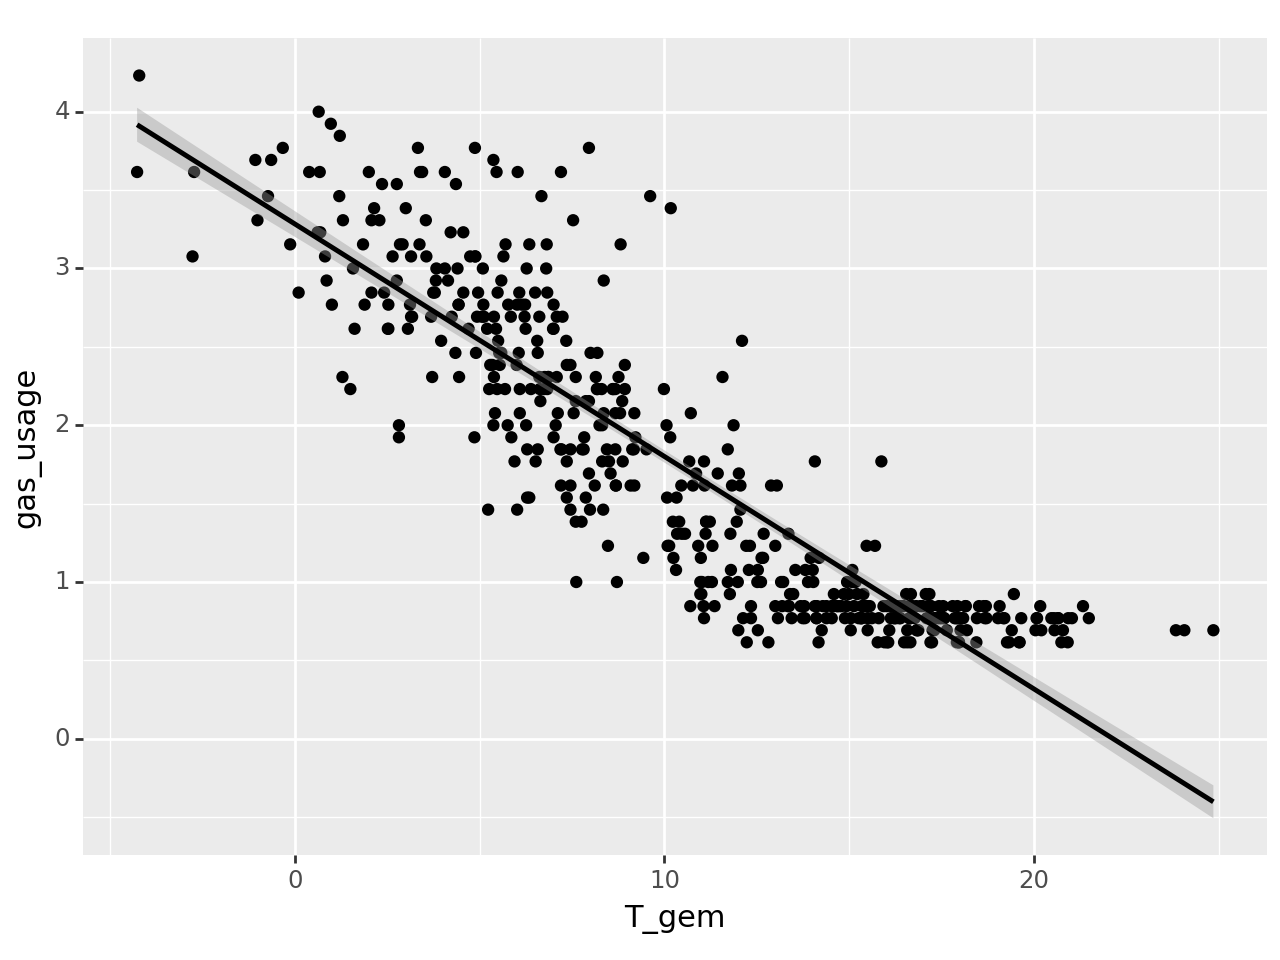

<Figure Size: (640 x 480)>

In [8]:
gas_usage = (
    energy_usage['gas_usage']
      .resample('W').sum().reset_index()
      .merge(temperature.resample('W').mean().reset_index(), left_on='Datum', right_on='date')
)

# Some obviously wrong data eliminated
gas_usage = gas_usage.query('gas_usage >= 0.55')

# Eliminate weeks that do not have the full 7 days, because we sum the data over the days
# and for those non-complete weeks this would underestimate the gas_usage, thus skewing the results
non_complete_weeks = (
    energy_usage['gas_usage']
      .resample('W').count() != 7
)
non_complete_dates = non_complete_weeks.loc[non_complete_weeks].index.values
gas_usage = (
  gas_usage.loc[~gas_usage['Datum'].isin(non_complete_dates)]
     .reset_index().drop(columns='index') # This is sadly needed as plotnine will throw an error without it. Might be connected to the new index not being contiguous anymore
)

(
    ggplot(gas_usage, aes(x='T_gem', y='gas_usage')) 
      + geom_point()
      + geom_smooth(method='lm')
)

In [9]:
# highres plot save
gg = (
    ggplot(gas_usage, aes(x='T_gem', y='gas_usage')) 
      + geom_point()
      + geom_smooth(method='lm')
)

ggsave(gg, 'pics/gas_usage_vs_tgem.png', dpi=200)

/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: pics/gas_usage_vs_tgem.png


Which clearly shows that there is a very strong correlation between temperature and gas usage. Using this effect as a baseline, we can now try and model the effect of replacing out central heating boiler. 

# Benchmarking the central heating boiler
Our first step in benchmarking the boiler is to create a series boxplots of gas usage per month. In addition, for the few months post install of the new boiler we add separate boxes:

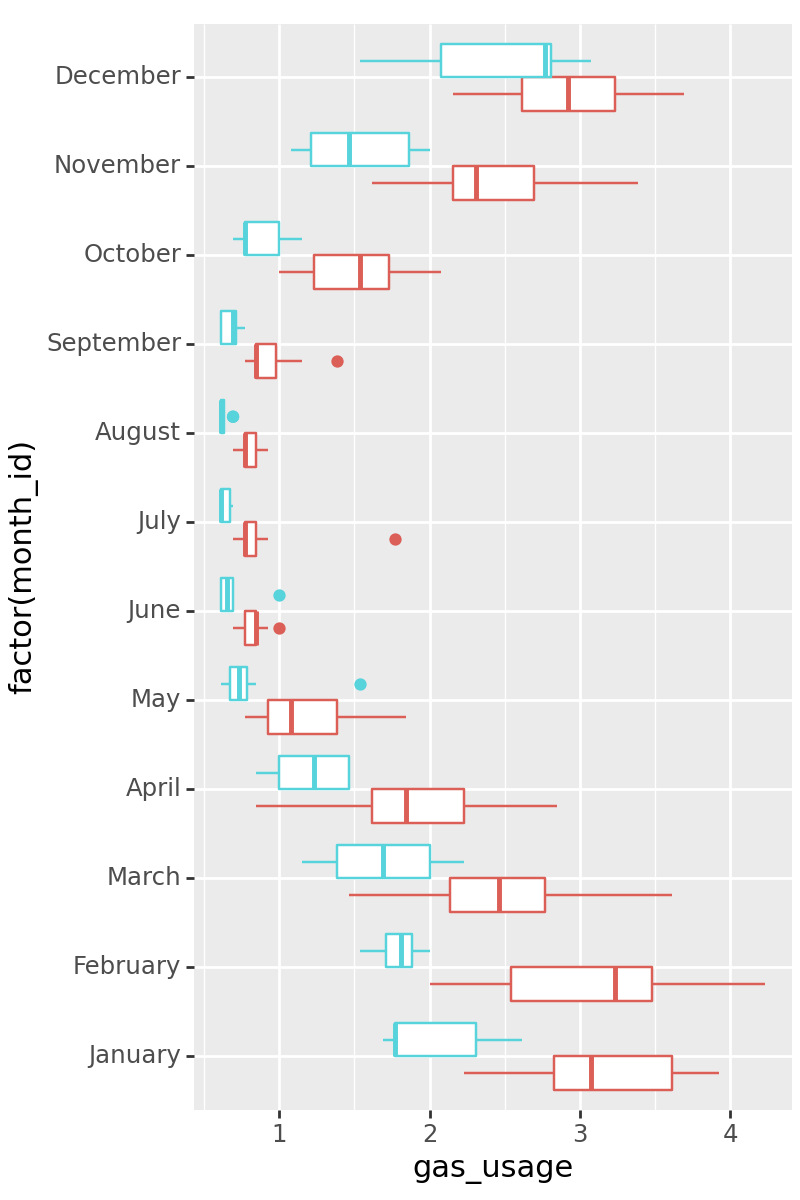

<Figure Size: (400 x 600)>

In [10]:
gas_usage["month_id"] = pd.Categorical(gas_usage['Datum'].dt.strftime('%B'), categories=calendar.month_name[1:]) # Settings categories here to force the correct order on the axis
gas_usage["year_id"] = pd.Categorical(gas_usage['Datum'].dt.strftime('%Y'))
gas_usage['post_install'] = gas_usage['Datum'] > 'May 2022'

(
    ggplot(gas_usage)
      + geom_boxplot(aes(x='factor(month_id)', y='gas_usage', color='factor(post_install)'), position='dodge', show_legend=False)
      + coord_flip()
      + theme(figure_size=(4,6))
)

In [11]:
gg = (
    ggplot(gas_usage)
      + geom_boxplot(aes(x='factor(month_id)', y='gas_usage', color='factor(post_install)'), position='dodge', show_legend=False)
      + coord_flip()
      + theme(figure_size=(4,6))
)

ggsave(gg, 'pics/gas_usage_boxplot.png', dpi=200)

/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 6 in image.
/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: pics/gas_usage_boxplot.png


Which shows us the first hint that the new boiler uses less gas with the post install months (May-Sept, cyan boxes) showing much lower gas usage. The next step is the recreate our temperature versus gas usage plot for both pre and post install data:

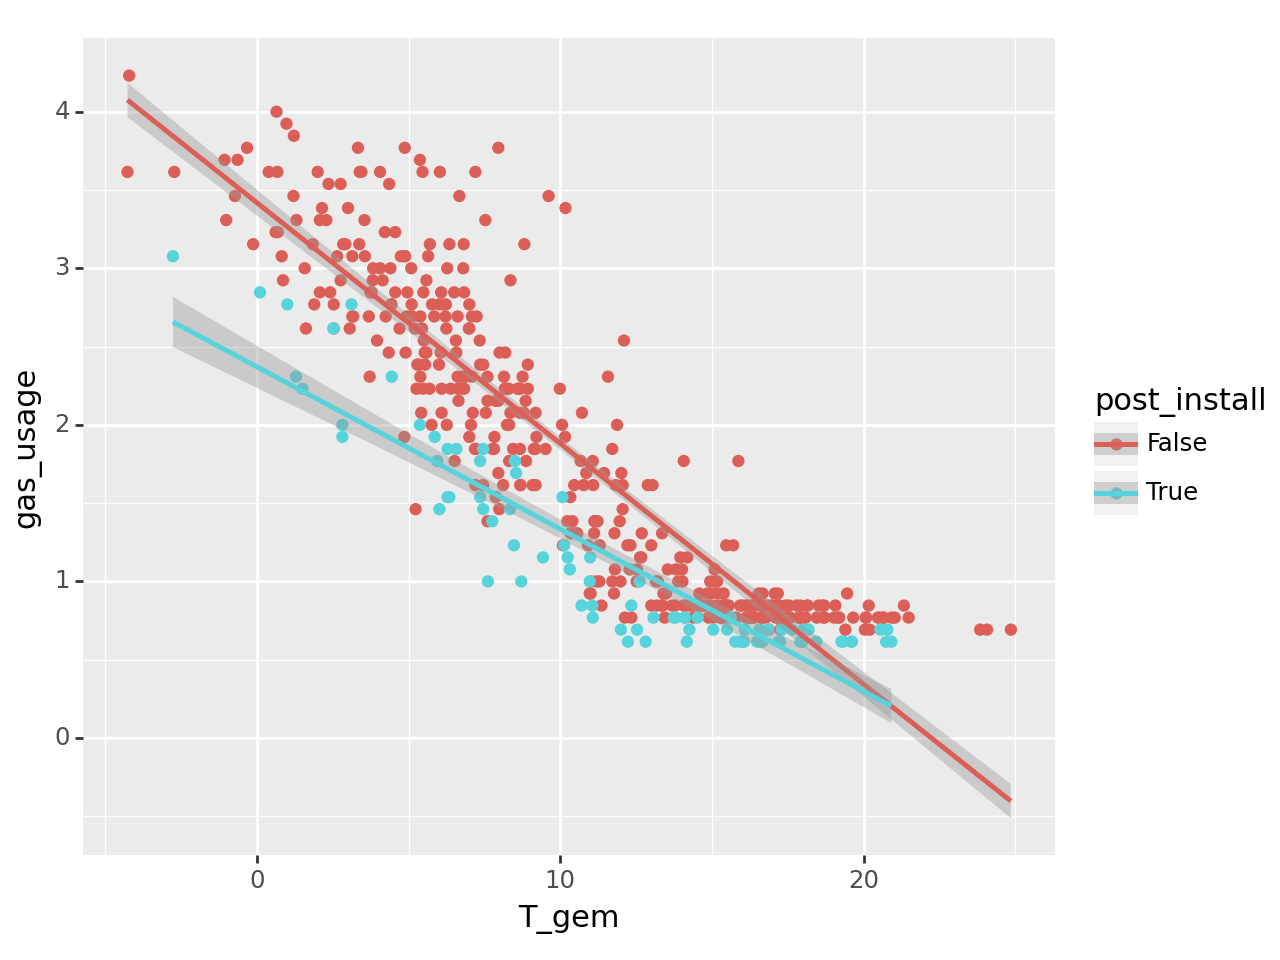

<Figure Size: (640 x 480)>

In [12]:
(
    ggplot(gas_usage, aes(x='T_gem', y='gas_usage', color='post_install')) 
      + geom_point()
      + geom_smooth(method='lm')
)

In [13]:
gg = (
    ggplot(gas_usage, aes(x='T_gem', y='gas_usage', color='post_install')) 
      + geom_point()
      + geom_smooth(method='lm')
)

ggsave(gg, 'pics/gas_usage_tgem_prepost.png', dpi=200)

/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: pics/gas_usage_tgem_prepost.png


This confirms our earlier observation: gas usage is lower and the effect seems to scale with temperature as the slope of the regression line is significantly lower. However, the post install data is still very limited and not a lot of weeks are included where our heating was triggered because of the cold. But given the very high gas prices currently, this provides me with some hope that we can get through the winter with less gas than the previous winter. 

To quantify the effect we create a regression model using statsmodels' formula interface. Note we cannot simply include our two variables in the formula like this `T_gem + C(post_install)`, as this will only allow the intercept to be different between the lines. This is clearly not what we want given the result of the plot above, we want varying slopes post and pre install. The solution is to use interactions, i.e. telling the regression model the relationship between `T_gem` and `gas_usage` varies based on `C(post_install)`. In the formula you can specify this using a `*`: `T_gem * C(post_install)`. This means the relationship (slope) between `gas_usage` and `T_gem` can be different for the two values of `C(post_install)`, resulting in the two lines in the plot above. Running the code yields:

In [14]:
import statsmodels.formula.api as smf

res = smf.ols(formula='gas_usage ~ T_gem * C(post_install)', data=gas_usage).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              gas_usage   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     818.4
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          2.34e-190
Time:                        12:44:24   Log-Likelihood:                -236.36
No. Observations:                 494   AIC:                             480.7
Df Residuals:                     490   BIC:                             497.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

where the coefficients need to be interpreted as:

- `Intercept` the (anonimized) gas usage at zero degrees centigrade
- `C(post_install)[T.True]` at zero degrees, the new boiler uses 1.05 less gas
- `T_gem` for each degree increase in temperature from 0 the gas usage drops 0.15
- `T_gem:C(post_install)[T.True]` the new boiler changes the slope of T_gem by 0.05. This makes the slope (-0.15 + 0.05) = 0.10, which means the gas usage drops less aggressively with temperature.

The added effect of these coefficients is what we expect: the new boiler uses less gas but the absolute effect becomes less strong with higher temperatures. The following regression formula further illustrates the point:

![](pics/interaction_math.png)

# Conclusion
For the limited dataset I have post install of my new boiler, things are looking good. It uses less gas, and will hopefully significantly impact my utility bill. There are however some limitations: the data post install is quite limited compared to the years worth of pre install data, especially because no post install winter is included in the data. This coming winter I will of course collect more data, which will provide more certainty. One potential disturbing factor could be that we turned down our thermostat down to 18 degrees, almost certainly impacting our gas usage. But this is an interesting topic to tackle in spring. 

Update dec 2023: I updated the data, this shows almost the same patterns in usage. We increased our thermostat a little bit towards our pre-crisis levels. The final plot in `alternative_plots.ipynb` (github) confirms that this did not change the pattern significantly, we still use much less gas when it is really cold. 